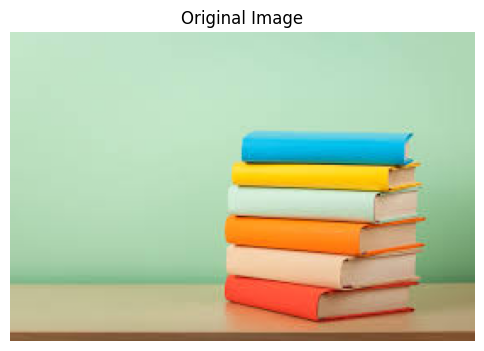

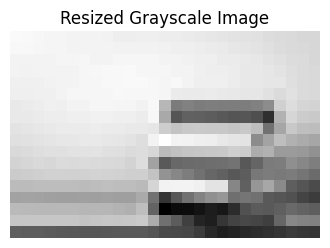

In [ ]:
import torch
from torchvision import transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage import img_as_float

# Load the image using PIL
image_path = '/content/drive/MyDrive/AIP Assignment 2/Question 1/img3.jpeg'
image_pil = Image.open(image_path)

# Define a transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

# Apply the transformation to the image
image_tensor = transform(image_pil)

# Display the original image to verify it's loaded correctly
plt.figure(figsize=(6, 6))
plt.imshow(image_tensor.permute(1, 2, 0))  # Permute the tensor dimensions to display the image correctly
plt.axis('off')  # Hide the axis
plt.title("Original Image")
plt.show()

# Define new size for resizing the image (1/10th of original for both dimensions)
original_size = image_tensor.shape[1:]  # Original size (height, width)
new_size = (int(original_size[1] / 10), int(original_size[0] / 10))  # New size (width, height)

# Resize the image
small_image_pil = image_pil.resize(new_size, Image.LANCZOS)  # Used LANCZOS for high-quality downsampling

# Convert the resized image to grayscale
small_image_gray = rgb2gray(np.array(small_image_pil))
small_image_gray = img_as_float(small_image_gray)

# Display the resized grayscale image for verification
plt.figure(figsize=(4, 4))
plt.imshow(small_image_gray, cmap='gray')
plt.axis('off')  # Hide the axis
plt.title("Resized Grayscale Image")
plt.show()

# Function to calculate weight between two pixels
def calculate_weight(p1, p2, flat_image, sigma_I=0.1):
    intensity_diff = np.abs(flat_image[p1] - flat_image[p2])
    weight = np.exp(-intensity_diff**2 / (2 * sigma_I**2))
    return weight

# Function to construct the similarity graph for the resized grayscale image
def construct_similarity_graph_small(image):
    h, w = image.shape
    n_pixels = h * w
    flat_image = image.flatten()
    W = np.zeros((n_pixels, n_pixels))

    for i in range(n_pixels):
        for j in range(i + 1, n_pixels):  # Only compute for one half and mirror since W is symmetric
            weight = calculate_weight(i, j, flat_image)
            W[i, j] = W[j, i] = weight

    return W

# Construct the similarity graph for the resized grayscale image
W_small = construct_similarity_graph_small(small_image_gray)

In [ ]:
import numpy as np

# W_small is similarity matrix from the previous step

# Step 3: Calculate the Degree Matrix (D)
D = np.diag(np.sum(W_small, axis=1))

# Step 4: Formulate the Laplacian Matrix (L)
L = D - W_small

# Displaying the shapes of the matrices for verification
print("Shape of D:", D.shape)
print("Shape of L:", L.shape)

Shape of D: (486, 486)
Shape of L: (486, 486)


In [ ]:
import numpy as np

# Solving for eigenvalues and eigenvectors of the Laplacian matrix
eigenvalues, eigenvectors = np.linalg.eigh(L)

# Sorting the eigenvalues and eigenvectors
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# The second smallest eigenvalue and its corresponding eigenvector
second_smallest_eigenvalue = eigenvalues[1]
second_smallest_eigenvector = eigenvectors[:, 1]

# Displaying the second smallest eigenvalue for verification
print("Second Smallest Eigenvalue:", second_smallest_eigenvalue)

Second Smallest Eigenvalue: 28.904263199223873


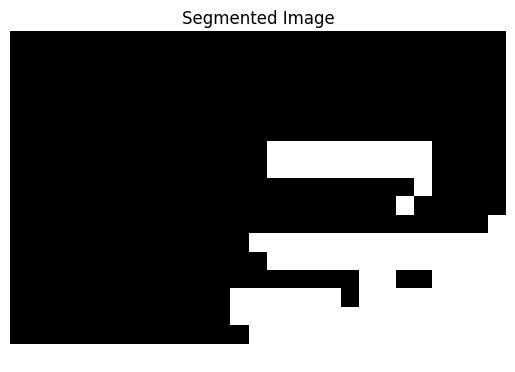

In [ ]:
# Partitioning the graph based on the second smallest eigenvector
labels = np.where(second_smallest_eigenvector > 0, 1, 0)

# Reshaping the labels back into the image shape to visualize the segmentation
segmented_image = labels.reshape(small_image_gray.shape)

# Visualizing the segmented image
plt.imshow(segmented_image, cmap='gray')
plt.title("Segmented Image")
plt.axis('off')
plt.show()

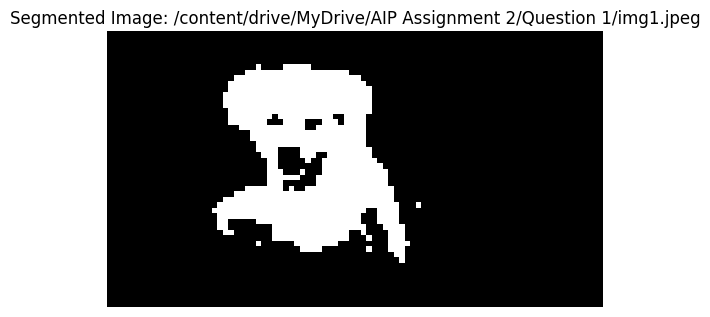

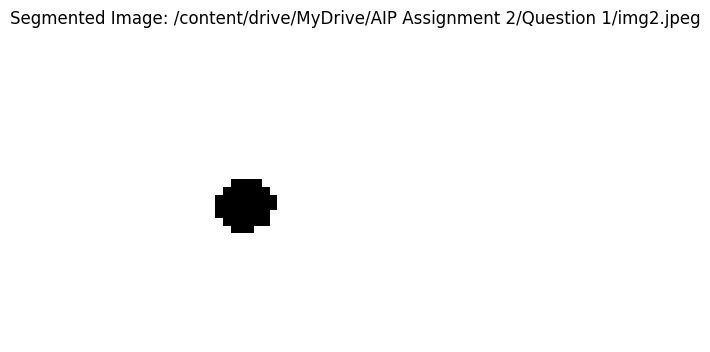

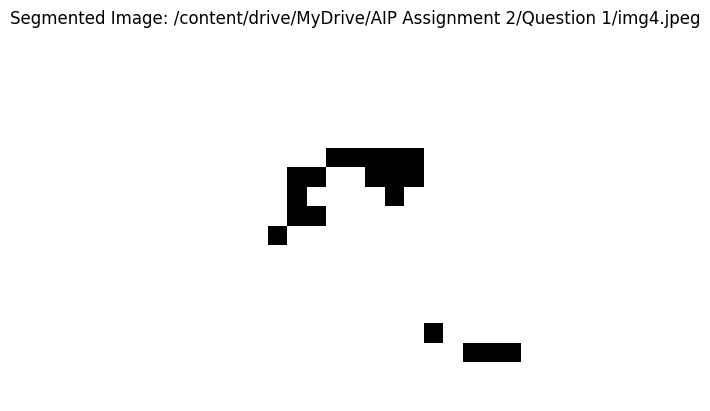

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import img_as_float
from torchvision import transforms

def load_and_preprocess_image(image_path, resize_scale=10):
    image_pil = Image.open(image_path)
    original_size = image_pil.size  # Original size (width, height)
    new_size = (original_size[0] // resize_scale, original_size[1] // resize_scale)
    small_image_pil = image_pil.resize(new_size, Image.LANCZOS)
    small_image_gray = rgb2gray(np.array(small_image_pil))
    return img_as_float(small_image_gray)

def segment_image(image_gray):
    W_small = construct_similarity_graph_small(image_gray)
    D = np.diag(np.sum(W_small, axis=1))
    L = D - W_small
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    idx = np.argsort(eigenvalues)
    second_smallest_eigenvector = eigenvectors[:, idx[1]]
    labels = np.where(second_smallest_eigenvector > 0, 1, 0)
    segmented_image = labels.reshape(image_gray.shape)
    return segmented_image

# Paths to images
image_paths = [
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img1.jpeg',
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img2.jpeg',
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img4.jpeg'
]

# Loop through each image, process it, and display the segmented result
for path in image_paths:
    image_gray = load_and_preprocess_image(path)
    segmented_image = segment_image(image_gray)

    plt.figure()
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"Segmented Image: {path}")
    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


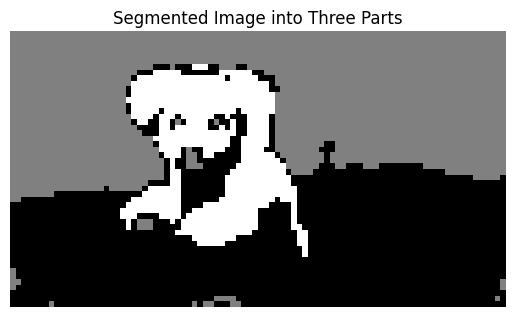

In [ ]:
from sklearn.cluster import KMeans

def segment_image_into_three(image_gray):
    W_small = construct_similarity_graph_small(image_gray)
    D = np.diag(np.sum(W_small, axis=1))
    L = D - W_small
    eigenvalues, eigenvectors = np.linalg.eigh(L)

    # Using the first three non-trivial eigenvectors for clustering
    idx = np.argsort(eigenvalues)[1:4]  # Skip the smallest eigenvalue, use the next three
    features_for_clustering = eigenvectors[:, idx]


    kmeans = KMeans(n_clusters=3, random_state=42).fit(features_for_clustering)
    labels = kmeans.labels_

    # Reshape labels to match the image shape for visualization
    segmented_image = labels.reshape(image_gray.shape)
    return segmented_image

# Choose an image to segment into three parts
image_path = '/content/drive/MyDrive/AIP Assignment 2/Question 1/img1.jpeg'
image_gray = load_and_preprocess_image(image_path)
segmented_image_three = segment_image_into_three(image_gray)

# Visualize the segmented image
plt.imshow(segmented_image_three, cmap='gray')
plt.title("Segmented Image into Three Parts")
plt.axis('off')
plt.show()


**Gaussian Similarity based on both spatial and color proximity for constructing the similarity graph in the N-cut algorithm**

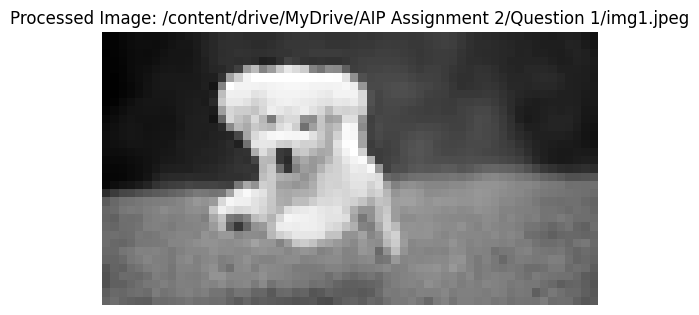

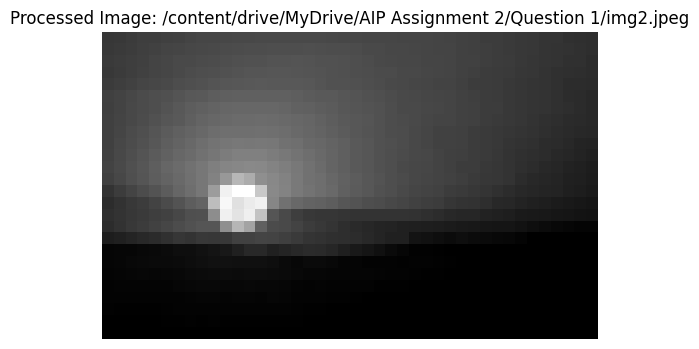

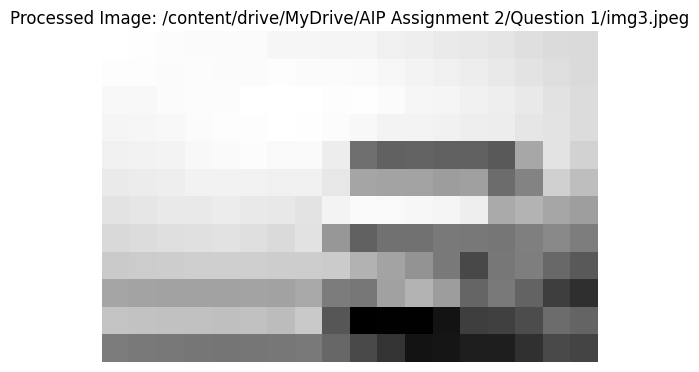

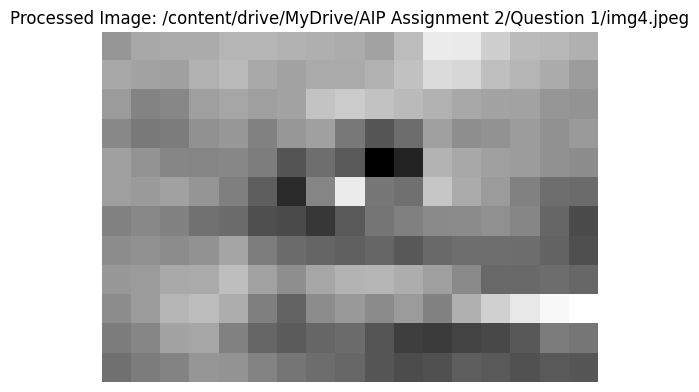

In [ ]:
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import img_as_float
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Function to load and preprocess an image
def load_and_preprocess_image(image_path, resize_scale=15):
    image_pil = Image.open(image_path)
    original_size = image_pil.size  # (width, height)
    new_size = (original_size[0] // resize_scale, original_size[1] // resize_scale)
    image_pil = image_pil.resize(new_size, Image.LANCZOS)
    image_gray = rgb2gray(np.array(image_pil))
    return img_as_float(image_gray)

# Adjusted function for calculating Gaussian similarity with spatial and color proximity
def calculate_gaussian_similarity(p1, p2, flat_image, positions, sigma_I=0.1, sigma_X=1.0):
    intensity_diff = np.abs(flat_image[p1] - flat_image[p2])
    spatial_dist = np.linalg.norm(positions[p1] - positions[p2])
    weight = np.exp(-intensity_diff**2 / (2 * sigma_I**2) - spatial_dist**2 / (2 * sigma_X**2))
    return weight

# Function to construct the similarity graph using Gaussian similarity
def construct_similarity_graph_with_spatial(image):
    h, w = image.shape
    n_pixels = h * w
    flat_image = image.flatten()
    x, y = np.meshgrid(range(w), range(h))
    positions = np.stack([x.flatten(), y.flatten()], axis=1)
    W = np.zeros((n_pixels, n_pixels))

    for i in range(n_pixels):
        for j in range(i+1, n_pixels):  # Compute only for one half because of symmetry
            W[i, j] = W[j, i] = calculate_gaussian_similarity(i, j, flat_image, positions)

    return W

image_paths = [
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img1.jpeg',
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img2.jpeg',
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img3.jpeg',
    '/content/drive/MyDrive/AIP Assignment 2/Question 1/img4.jpeg'
]

# Process each image
for image_path in image_paths:
    image_gray = load_and_preprocess_image(image_path)
    W = construct_similarity_graph_with_spatial(image_gray)
    plt.figure()
    plt.imshow(image_gray, cmap='gray')
    plt.title(f"Processed Image: {image_path}")
    plt.axis('off')
    plt.show()

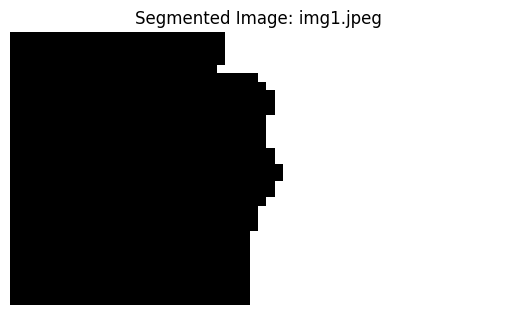

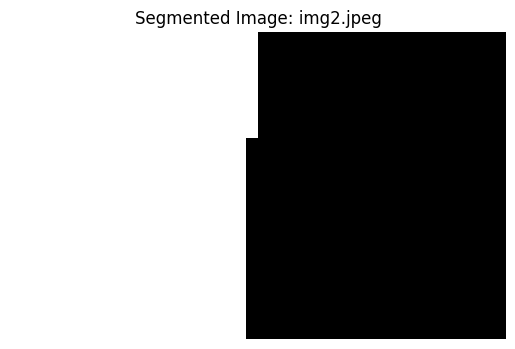

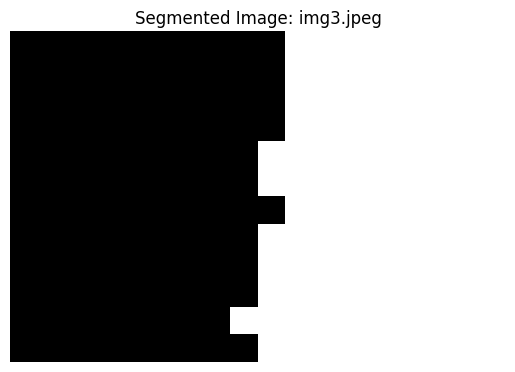

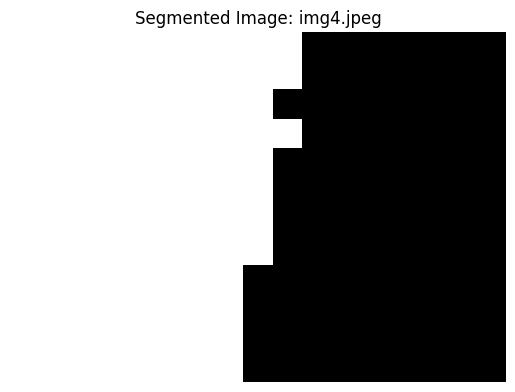

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

def calculate_degree_laplacian(W):
    D = np.diag(np.sum(W, axis=0))
    L = D - W
    return D, L

def segment_image_into_two(W, image_shape):
    D, L = calculate_degree_laplacian(W)
    # Using scipy to handle sparse matrices for efficiency
    L_sparse = csr_matrix(L)
    # Solve for the 2 smallest eigenvalues and their eigenvectors
    eigenvalues, eigenvectors = eigsh(L_sparse, k=2, which='SM')
    # Use the second smallest eigenvector for partitioning
    second_smallest_eigenvector = eigenvectors[:, 1]
    labels = np.where(second_smallest_eigenvector > 0, 1, 0)
    segmented_image = labels.reshape(image_shape)
    return segmented_image

# Segment each image and display the results
for image_path in image_paths:
    image_gray = load_and_preprocess_image(image_path)
    W = construct_similarity_graph_with_spatial(image_gray)
    segmented_image = segment_image_into_two(W, image_gray.shape)

    # Visualize the segmented image
    plt.figure()
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f"Segmented Image: {image_path.split('/')[-1]}")
    plt.axis('off')
    plt.show()